In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import pandas as pd
import glob
import os
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

##### path declaration 

In [3]:
station_path = '/content/drive/MyDrive/ML_Project_Solar/dataset/station_info.csv'
train_path = '/content/drive/MyDrive/ML_Project_Solar/dataset/train.csv'
test_path = '/content/drive/MyDrive/ML_Project_Solar/dataset/test.csv'
elevation_path = '/content/drive/MyDrive/ML_Project_Solar/dataset/gefs_elevations.nc';
train_weather_file_list = glob.glob('/content/drive/MyDrive/ML_Project_Solar/dataset/gefs_train_updated/train/*.nc')
test_weather_file_list = glob.glob('/content/drive/MyDrive/ML_Project_Solar/dataset/gefs_test_updated/test/*.nc')

## Preprocessing

### helper functions

In [4]:
def get_elevations_df(path):
  elevation = xr.open_dataset(elevation_path)
  df = elevation.to_dataframe().reset_index()
  df.drop(columns=["lat", "lon"], inplace=True)
  df.rename(columns={'latitude': 'nearest_lat', 'longitude': 'nearest_lon'}, inplace=True)
  return df

In [5]:
stations = pd.read_csv(station_path)
train_data = pd.read_csv(train_path)
elevation = get_elevations_df(elevation_path)

In [6]:
test_data = pd.read_csv(test_path)

In [7]:
def stations_elevation_data_preprocessing(stations, elevation):
  stations["nearest_lat"] = np.NaN
  stations["nearest_lon"] = np.NaN
  stations["elevation_control"] = np.NaN
  stations["elevation_perturbation"] = np.NaN

  for index, row in stations.iterrows():
    lat, lon = closest_gridpoint(row["stid"])
    stations.at[index, "nearest_lat"] = lat
    stations.at[index, "nearest_lon"] = lon
    stations.at[index, "elevation_control"] = elevation.loc[(elevation.nearest_lat == lat) & (elevation.nearest_lon == lon),  "elevation_control"]
    stations.at[index, "elevation_perturbation"] = elevation.loc[(elevation.nearest_lat == lat) & (elevation.nearest_lon == lon),  "elevation_perturbation"]
 
  final = stations.copy()
  stations.drop(columns=["nearest_lat", "nearest_lon", "elevation_control", "elevation_perturbation"], inplace=True)
  return final

In [8]:
def combine_stations_with_train_data(stations, train_data):
  train_data_melt = pd.melt(train_data, id_vars='Date', var_name='stid', value_name='energy')
  final = pd.merge(train_data_melt, stations)
  final['elon'] = final['elon'] + 360
  return final

In [9]:
def date_preprocessing(df):
  date_list = df['Date'].unique()
  date_list.sort()
  final_dt = []
  
  for i, date in enumerate(date_list):
    temp = [i, date]
    final_dt.append(temp)

  date_df = pd.DataFrame(final_dt, columns=['date_id', 'Date'])
  df = pd.merge(df, date_df)

  df["year"] = df["Date"].astype("str").str.slice(0, 4)
  df["month"] = df["Date"].astype("str").str.slice(4, 6)
  df["day"] = df["Date"].astype("str").str.slice(6, 8)

  return df


In [10]:
def closest_gridpoint(station_id):
    '''
    returns closest longitude latitude point
    '''
    st_lat = stations[stations.stid == station_id]['nlat'].iloc[0]
    st_lon = stations[stations.stid == station_id]['elon'].iloc[0] + 360

    lats = list(range(31,40))
    lons = list(range(254,270))
    
    lat_dif = list(abs(lats - st_lat))
    lon_dif = list(abs(lons - st_lon))
    
    return lats[lat_dif.index(min(lat_dif))], lons[lon_dif.index(min(lon_dif))]

In [11]:
def predict_daily_mean(path, df_1, type):
  """
    calculates daily mean of forcast value at each station at particular date using its closest GEFS point.
  """
  const = 0

  if type == 0:
    const = 98
  else:
    const = 6

  df = df_1.copy()
  stations_id = df['stid'].unique()
  date_id = df['date_id'].unique()

  nc_dataset = nc.Dataset(path)
  w_variable_name = list(nc_dataset.variables.keys())[-1]

  df[w_variable_name] = np.NaN

  if(type == 0):
    for i, station_id in enumerate(stations_id):
      X = get_station_wise_data(path, station_id)

      for j, date in enumerate(date_id):
        date_wise_data = X[date, :, :]
        daily_mean_value = np.ma.mean(date_wise_data)
        # df.loc[(df.stid == station_id) & (df.date_id == date), w_variable_name] = daily_mean_value
        df.at[i + const*j , w_variable_name] = daily_mean_value
  else:
    for i, station_id in enumerate(stations_id):
      X = get_station_wise_data(path, station_id)

      for j, date in enumerate(date_id):
        date_wise_data = X[date, :, :]
        daily_mean_value = np.ma.mean(date_wise_data)
        # df.at[i + const*j , w_variable_name] = daily_mean_value   
        df.loc[(df.stid == station_id) & (df.date_id == date), w_variable_name] = daily_mean_value
  return df

In [12]:
def predict_hourly_median(path, df_1, type):
  const = 6

  # if type == 0:
  #   const = 98
  # else:
  #   const = 6

  df = df_1.copy()
  stations_id = df['stid'].unique()
  date_id = df['date_id'].unique()

  nc_dataset = nc.Dataset(path)
  w_variable_name = list(nc_dataset.variables.keys())[-1]

  if(type == 0):
    for i, station_id in enumerate(stations_id):
      X = get_station_wise_data(path, station_id)

      for j, date in enumerate(date_id):
        date_wise_data = X[date, :, :]

        for hour in range(5):
          hourly_median_value = np.ma.median(date_wise_data[:, hour])
          hour = hour + 1
          df.at[i + const*j , w_variable_name + str(hour)] = hourly_median_value
  else:
    for i, station_id in enumerate(stations_id):
      X = get_station_wise_data(path, station_id)

      for j, date in enumerate(date_id):
        date_wise_data = X[date, :, :]

        for hour in range(5):
          hourly_median_value = np.ma.median(date_wise_data[:, hour])
          hour = hour + 1
          # df.at[i + const*j , w_variable_name + str(hour)] = hourly_median_value    
          df.loc[(df.stid == station_id) & (df.date_id == date), w_variable_name + str(hour)] = hourly_median_value
        
  return df

In [13]:
def get_station_wise_data(path, stid):
  lat, lon = closest_gridpoint(stid)
  nc_dataset = nc.Dataset(path, 'r')
  nc_dataset_variable_values = nc_dataset.variables.values()

  X_lat = list(nc_dataset_variable_values)[2]
  X_lon = list(nc_dataset_variable_values)[3]
  X_ind = []
  
  for i in range(len(X_lat)):
    for j in range(len(X_lon)):
      if (X_lat[i] == lat and X_lon[j] == lon):
        X_ind.append((i, j))

  X = []
  for i, j in X_ind:
    X.append(list(nc_dataset_variable_values)[-1][:, :, :, i, j])
  return X[0]

In [14]:
# def get_nearest_4_station_wise_data(path, stid):
#   lat, lon = closest_gridpoint(stid)
#   nc_dataset = nc.Dataset(path, 'r')
#   nc_dataset_variable_values = nc_dataset.variables.values()

#   X_lat = list(nc_dataset_variable_values)[2]
#   X_lon = list(nc_dataset_variable_values)[3]
#   X_ind = []

#   lats

#   for i in range(len(X_lat)):
#     for j in range(len(X_lon)):
#       if (X_lat[i] == lat and X_lon[j] == lon):
#         X_ind.append((i, j))

#   X = []
#   for i, j in X_ind:
#     X.append(list(nc_dataset_variable_values)[-1][:, :, :, i, j])
#   return X[0]

### Taking mean of daily forecast value by each 11 ensemble for all 15 forecast models



In [15]:
def final_train_data_using_daily_mean_fun(weather_file_list, stations, elevation, train_data):
  df = stations_elevation_data_preprocessing(stations, elevation)
  df = combine_stations_with_train_data(df, train_data)
  df = date_preprocessing(df)
  final_data_using_daily_mean = df

  print("0/15...")
  for i, weather_file in enumerate(weather_file_list):
    df1 = predict_daily_mean(weather_file, df[['stid', 'date_id']], 0)
    print(str(i+1) + "/15...")
    final_data_using_daily_mean = final_data_using_daily_mean.merge(df1)
  
  final_data_using_daily_mean["Date"] = final_data_using_daily_mean["Date"].astype(str)
  final_data_using_daily_mean["Date"] = final_data_using_daily_mean["stid"] + "-" + final_data_using_daily_mean["Date"]
  final_data_using_daily_mean.drop(columns=["date_id", "nearest_lat", "nearest_lon"], inplace=True)

  # final_data_using_daily_mean.to_csv('6_st_train_data_using_daily_mean_of_nearest_lat_lon.csv', index=False)
  # files.download('train_data_using_daily_mean_of_nearest_lat_lon.csv')
  return final_data_using_daily_mean

In [16]:
def final_test_data_using_daily_mean_fun(weather_file_list, stations, elevation, test_path):
  test_df = pd.read_csv(test_path)
  test = test_df["Date"].str.split("-", n = 1, expand = True)
  test_df["Date"] = test[1]
  test_df["stid"] = test[0]
  df = test_df.merge(stations)
  df["elon"] = df["elon"] + 360

  df = date_preprocessing(df)
  st = stations_elevation_data_preprocessing(stations, elevation)
  df = pd.merge(df, st[["stid", "elevation_control", "elevation_perturbation"]], on="stid")
  df["date_id"] = df["date_id"]+4018
  final_data_using_daily_mean = df

  print("0/15...")
  for i, weather_file in enumerate(weather_file_list):
    df1 = predict_daily_mean(weather_file, df[['stid', 'date_id']], 1)
    print(str(i+1) + "/15...")
    final_data_using_daily_mean = final_data_using_daily_mean.merge(df1)
  
  final_data_using_daily_mean["Date"] = final_data_using_daily_mean["Date"].astype(str)
  final_data_using_daily_mean["Date"] = final_data_using_daily_mean["stid"] + "-" + final_data_using_daily_mean["Date"]
  final_data_using_daily_mean.drop(columns=["date_id"], inplace=True)

  final_data_using_daily_mean.to_csv('test_mean.csv', index=False)
  # files.download('test_data_using_daily_mean_of_nearest_lat_lon.csv')
  return final_data_using_daily_mean

In [17]:
%%time
train_data_using_daily_mean = final_train_data_using_daily_mean_fun(train_weather_file_list, stations, elevation, train_data)

0/15...
1/15...
2/15...
3/15...
4/15...
5/15...
6/15...
7/15...
8/15...
9/15...
10/15...
11/15...
12/15...
13/15...
14/15...
15/15...
CPU times: user 19min 14s, sys: 21.6 s, total: 19min 36s
Wall time: 21min 35s


In [29]:
def generate_required_station_data_only(df):
  stations = ["HINT", "IDAB", "SLAP", "WEST", "BESS", "ACME"]
  final = pd.DataFrame(columns=list(df.columns))

  for station in stations:
    final = final.append(df[df.stid == station])

  final.to_csv("train_data1.csv", index=False)

In [30]:
generate_required_station_data_only(train_data_using_daily_mean)

In [31]:
!cp /content/train_data1.csv /content/drive/MyDrive/ML_Project_Solar/afinal\ sheets/

In [34]:
train_data_using_daily_mean

,Date,stid,energy,nlat,elon,elev,elevation_control,elevation_perturbation,year,month,day,Downward_Short-Wave_Rad_Flux,Total_precipitation,Downward_Long-Wave_Rad_Flux,Pressure,Precipitable_water,Specific_humidity_height_above_ground,Maximum_temperature,Minimum_temperature,Temperature_height_above_ground,Total_cloud_cover,Upward_Long-Wave_Rad_Flux,Upward_Long-Wave_Rad_Flux_surface,Total_Column-Integrated_Condensate,Upward_Short-Wave_Rad_Flux,Temperature_surface
0,ACME-19940101,ACME,12384900,34.80833,261.97675,397,372.147064,393.638275,1994,01,01,219.090912,0.000000,258.641846,102023.773438,8.086299,0.003322,284.397034,280.260590,282.354340,0.001273,254.383820,364.319794,0.002298,47.745453,282.548523
1,ADAX-19940101,ADAX,11930700,34.79851,263.33091,295,311.572968,308.563354,1994,01,01,218.000000,0.000000,260.423645,101979.492188,8.100845,0.003544,283.982513,280.582397,282.481201,0.000182,250.565643,362.374329,0.000811,47.727272,282.490356
2,ALTU-19940101,ALTU,12116700,34.58722,260.66192,416,477.432709,464.848663,1994,01,01,220.727280,0.000000,256.769104,102062.164062,7.960845,0.003111,284.615234,279.917511,282.260651,0.001273,254.929276,365.283417,0.001891,50.127274,282.543060
3,APAC-19940101,APAC,12301200,34.91418,261.70784,440,372.147064,393.638275,1994,01,01,219.090912,0.000000,258.641846,102023.773438,8.086299,0.003322,284.397034,280.260590,282.354340,0.001273,254.383820,364.319794,0.002298,47.745453,282.548523
4,ARNE-19940101,ARNE,10706100,36.07204,260.09692,719,732.948853,744.821289,1994,01,01,212.000000,0.000000,247.423645,102071.281250,7.471754,0.002525,282.620697,278.457672,280.588135,0.003273,249.365646,357.356140,0.004100,50.727272,281.341278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393759,WEST-20041231,WEST,5932800,36.01100,265.35504,348,266.801971,247.777985,2004,12,31,123.818184,0.089455,354.291321,101829.109375,20.016762,0.010116,290.302979,288.231720,289.589386,0.054000,270.508698,397.067902,0.054416,22.490910,289.526855
393760,WILB-20041231,WILB,10899900,34.90092,264.65195,199,226.777283,235.344528,2004,12,31,115.272728,0.139636,364.600433,101900.242188,23.094944,0.010783,291.065887,289.218079,290.355927,0.058364,274.199585,401.940613,0.059500,16.472727,290.275909
393761,WIST-20041231,WIST,6348300,34.98426,265.31222,143,226.777283,235.344528,2004,12,31,115.272728,0.139636,364.600433,101900.242188,23.094944,0.010783,291.065887,289.218079,290.355927,0.058364,274.199585,401.940613,0.059500,16.472727,290.275909
393762,WOOD-20041231,WOOD,9421200,36.42329,260.58318,625,570.209534,552.047974,2004,12,31,204.909088,0.000000,280.164001,101552.835938,9.629488,0.005533,288.403351,284.365387,286.851593,0.008545,259.945068,381.376984,0.008289,45.545456,286.690460


In [33]:
%%time
test_data_using_daily_mean = final_test_data_using_daily_mean_fun(train_weather_file_list, stations, elevation, test_path)

0/15...
1/15...
2/15...
3/15...
4/15...
5/15...
6/15...
7/15...
8/15...
9/15...
10/15...
11/15...
12/15...
13/15...
14/15...
15/15...
CPU times: user 3min, sys: 2 s, total: 3min 2s
Wall time: 3min 6s


In [35]:
test_data_using_daily_mean.isna().sum()

Date                                     0
stid                                     0
nlat                                     0
elon                                     0
elev                                     0
year                                     0
month                                    0
day                                      0
elevation_control                        0
elevation_perturbation                   0
Downward_Short-Wave_Rad_Flux             0
Total_precipitation                      0
Downward_Long-Wave_Rad_Flux              0
Pressure                                 0
Precipitable_water                       0
Specific_humidity_height_above_ground    0
Maximum_temperature                      0
Minimum_temperature                      0
Temperature_height_above_ground          0
Total_cloud_cover                        0
Upward_Long-Wave_Rad_Flux                0
Upward_Long-Wave_Rad_Flux_surface        0
Total_Column-Integrated_Condensate       0
Upward_Shor

In [36]:
!cp /content/test_mean.csv /content/drive/MyDrive/ML_Project_Solar/afinal\ sheets/

### Taking median of hourly forecast value by each 11 ensemble for all 15 forecast models



In [ ]:
st = ["HINT", "IDAB", "SLAP", "WEST", "BESS", "ACME", "Date"]
train_data.drop(train_data.columns.difference(st), 1, inplace=True)
train_data

,Date,ACME,BESS,HINT,IDAB,SLAP,WEST
0,19940101,12384900,11487900,11604900,8080500,10265700,10644300
1,19940102,11908500,9235200,9581400,8595900,8584500,4082700
2,19940103,12470700,11895900,11727300,12386304,11369400,2746500
3,19940104,12725400,12186600,12158400,9291000,11779200,2741400
4,19940105,10894800,6411300,8381400,9488700,9345600,8235300
...,...,...,...,...,...,...,...
4013,20041227,7236300,10174200,9793200,10883400,9349200,9663300
4014,20041228,9362700,11340300,10608900,10698900,10725600,7700400
4015,20041229,6981000,6695400,6991200,3013800,8806200,2478600
4016,20041230,7562100,11021100,10560300,6143400,10517100,3936300


In [ ]:
train_data.isna().sum()

Date    0
ACME    0
BESS    0
HINT    0
IDAB    0
SLAP    0
WEST    0
dtype: int64

In [ ]:
stations = stations.loc[(stations["stid"] == "HINT") | (stations["stid"] == "IDAB") | (stations["stid"] == "SLAP") | (stations["stid"] == "WEST") | (stations["stid"] == "BESS") | (stations["stid"] == "ACME")  ]
stations

,stid,nlat,elon,elev
0,ACME,34.80833,-98.02325,397
6,BESS,35.40185,-99.05847,511
39,HINT,35.48439,-98.48151,493
44,IDAB,33.83013,-94.88030,110
78,SLAP,36.59749,-100.26192,774
93,WEST,36.01100,-94.64496,348


In [ ]:
def final_train_data_using_hourly_median_fun(weather_file_list, stations, elevation, train_data):
  df = stations_elevation_data_preprocessing(stations, elevation)
  df = combine_stations_with_train_data(df, train_data)
  df = date_preprocessing(df)
  final_data_using_hourly_median = df

  print("0/15...")
  for i, weather_file in enumerate(weather_file_list):
    df2 = predict_hourly_median(weather_file, df[['stid', 'date_id']], 0)
    print(str(i+1) + "/15...")
    final_data_using_hourly_median = final_data_using_hourly_median.merge(df2)

  
  final_data_using_hourly_median["Date"] = final_data_using_hourly_median["Date"].astype(str)
  final_data_using_hourly_median["Date"] = final_data_using_hourly_median["stid"] + "-" + final_data_using_hourly_median["Date"]
  final_data_using_hourly_median.drop(columns=["date_id", "nearest_lat", "nearest_lon"], inplace=True)

  final_data_using_hourly_median.to_csv('train_data_using_hourly_median_of_nearest_lat_lon.csv', index=False)
  # files.download('train_data_using_hourly_median_of_nearest_lat_lon.csv')
  return final_data_using_hourly_median

In [ ]:
def final_test_data_using_hourly_median_fun(weather_file_list, stations, elevation, test_path):
  test_df = pd.read_csv(test_path)
  test = test_df["Date"].str.split("-", n = 1, expand = True)
  test_df["Date"] = test[1]
  test_df["stid"] = test[0]
  df = test_df.merge(stations)
  df["elon"] = df["elon"] + 360

  df = date_preprocessing(df)
  st = stations_elevation_data_preprocessing(stations, elevation)
  df = pd.merge(df, st[["stid", "elevation_control", "elevation_perturbation"]], on="stid")
  final_data_using_hourly_median = df

  print("0/15...")
  for i, weather_file in enumerate(weather_file_list):
    df2 = predict_hourly_median(weather_file, df[['stid', 'date_id']], 1)
    print(str(i+1) + "/15...")
    final_data_using_hourly_median = final_data_using_hourly_median.merge(df2)

  
  final_data_using_hourly_median["Date"] = final_data_using_hourly_median["Date"].astype(str)
  final_data_using_hourly_median["Date"] = final_data_using_hourly_median["stid"] + "-" + final_data_using_hourly_median["Date"]
  final_data_using_hourly_median.drop(columns=["date_id"], inplace=True)

  final_data_using_hourly_median.to_csv('test_data_using_hourly_median_of_nearest_lat_lon.csv', index=False)
  # files.download('test_data_using_daily_mean_of_nearest_lat_lon.csv')
  return final_data_using_hourly_median

In [ ]:
%%time
train_data_using_hourly_median = final_train_data_using_hourly_median_fun(train_weather_file_list, stations, elevation, train_data)

0/15...
1/15...
2/15...
3/15...
4/15...
5/15...
6/15...
7/15...
8/15...
9/15...
10/15...
11/15...
12/15...
13/15...
14/15...
15/15...
CPU times: user 6min 19s, sys: 6.99 s, total: 6min 26s
Wall time: 6min 22s


In [ ]:
%%time
test_data_using_hourly_median = final_test_data_using_hourly_median_fun(test_weather_file_list, stations, elevation, test_path)

0/15...
1/15...
2/15...
3/15...
4/15...
5/15...
6/15...
7/15...
8/15...
9/15...
10/15...
11/15...
12/15...
13/15...
14/15...
15/15...
CPU times: user 13min 44s, sys: 4.36 s, total: 13min 48s
Wall time: 13min 46s


In [ ]:
train_data_using_hourly_median.to_csv('updated_train_data_using_hourly_median_of_nearest_lat_lon.csv', index=False)
test_data_using_hourly_median.to_csv('updated_test_data_using_hourly_median_of_nearest_lat_lon.csv', index=False)

In [ ]:
!cp /content/updated_train_data_using_hourly_median_of_nearest_lat_lon.csv /content/drive/MyDrive/ML_Project_Solar/Final/data/
!cp /content/updated_test_data_using_hourly_median_of_nearest_lat_lon.csv /content/drive/MyDrive/ML_Project_Solar/Final/data/

In [ ]:
test_data

# EDA

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/ML_Project_Solar/preprocessed data/train_data_using_daily_mean_of_nearest_lat_lon.csv")

NameError: ignored

In [ ]:
train_data.drop(columns=["elev"], inplace=True)

In [ ]:
train_data.describe()

In [ ]:
train_data.hist()
plt.show()

NameError: ignored

In [ ]:
def station_wise_monthly_energy(station, train_data):
  data = train_data[:][train_data.stid == station]
  sns.barplot(x=data["year"], y=data["energy"])

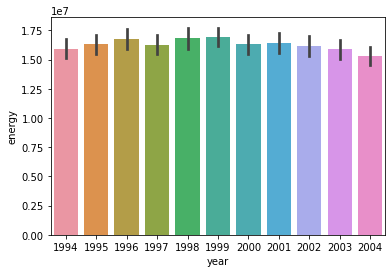

In [ ]:
station_wise_monthly_energy("ADAX", train_data)

In [ ]:
def station_wise_monthly_energy(station, train_data):
  data = train_data[:][train_data.stid == station]
  sns.barplot(x=data["year"], y=data["energy"])

In [ ]:
 !pip install pandas-profiling==2.7.1 

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
train_data = ProfileReport(train_data)


In [ ]:
train_data.to_file(output_file='output.html')

Summarize dataset:   0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
files.download('output.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model Training


In [ ]:
med = pd.read_csv('/content/drive/MyDrive/ML_Project_Solar/preprocessed data/train_data_using_hourly_median_of_nearest_lat_lon.csv')